# Data loading

We start by importing the packages and data.

In [1]:
%matplotlib inline
import scanpy.preprocessing
import scanpy.plotting
import scanpy.tools
import matplotlib.pyplot as plt
import scipy.stats
import pandas
import numpy

adata = scanpy.read_h5ad("../../Data/all_data.h5ad")

We make a quick heatmap to check whether the data looks sensible:

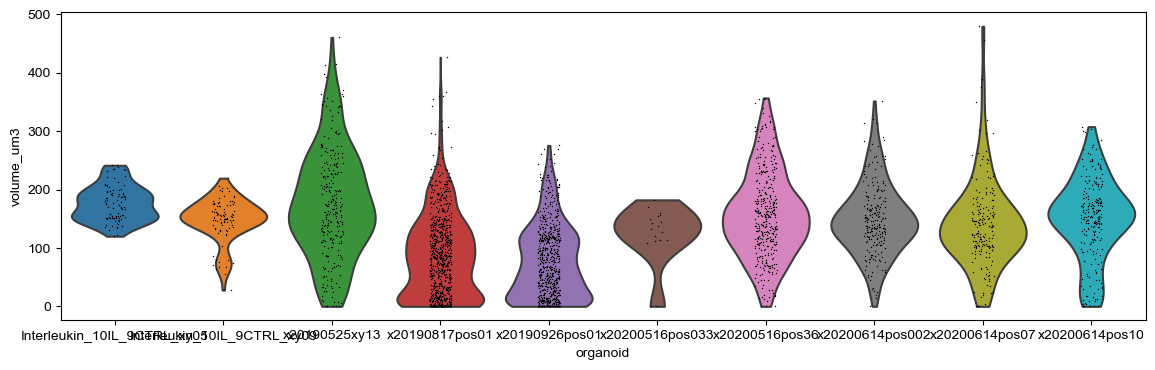

In [2]:
figure = plt.figure(figsize=(14, 4))
ax = figure.gca()
scanpy.plotting.violin(adata,
                       ax=ax,
                       keys=["volume_um3"], 
                       groupby="organoid")

We filter out cells with a suspiciously low or high volume: (indicating missegmentation)

In [3]:
adata = adata[adata[: , 'volume_um3'].X > 100, :]
adata = adata[adata[: , 'volume_um3'].X < 250, :]

# Start of analysis

Now we normalize the data:

In [4]:
scanpy.preprocessing.log1p(adata)
scanpy.preprocessing.scale(adata)

d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\preprocessing\_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


We also define a cell type palette that we will use everywhere:

In [5]:
cell_type_palette = {
    "ENTEROCYTE": "#100069",
    "OTHER_DIFFERENTIATED": "#100069",
    "ABSORPTIVE_PROGENY": "#0984e3",
    "SECRETORY": "#74b9ff",
    "ENTEROENDOCRINE": "#74b9ff",
    "GOBLET": "#74b9ff",
    "MATURE_GOBLET": "#74b9ff",
    "SECRETIVE_PROGENY": "#74b9ff",
    "WGA_PLUS": "#74b9ff",
    "OTHER_SECETORY": "#74b9ff",
    "PANETH": "#B60101",
    "STEM": "#26CC3C",
    "STEM_PUTATIVE": "#26CC3C",
    "UNLABELED": "#eeeeee",
    "TA": "#eeeeee",
    "NONE": "#ffffff"
}

Next, we plot the highly variable "genes" (or actually, nucleus parameters.)

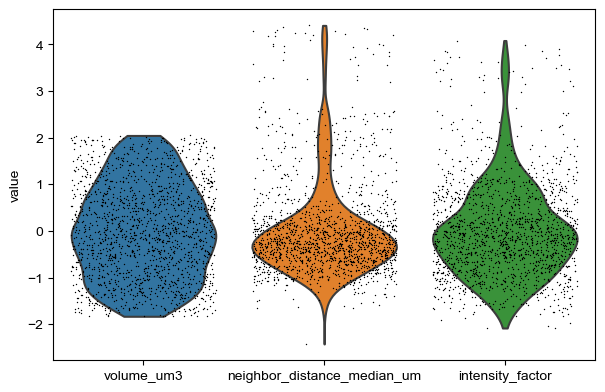

In [6]:

scanpy.plotting.violin(adata, ['volume_um3', 'neighbor_distance_median_um', 'intensity_factor'],
             jitter=0.4)


Next, we perform and plot the PCA:

KeyError: 'OTHER_SECRETORY'

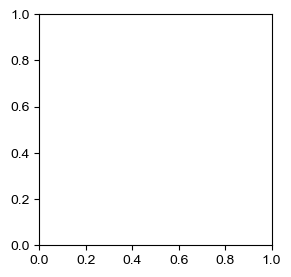

In [7]:
scanpy.tools.pca(adata, svd_solver='arpack')
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.pca(adata, ax=fig.gca(), annotate_var_explained=True, color="cell_type_training", palette=cell_type_palette, show=False)

And show the elbow plot:

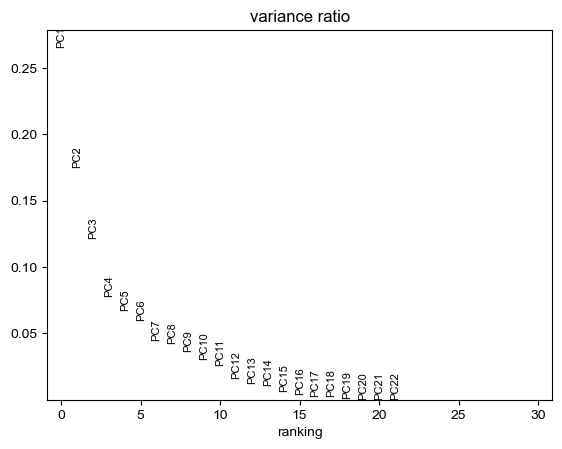

In [ ]:
scanpy.plotting.pca_variance_ratio(adata, log=False)

d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


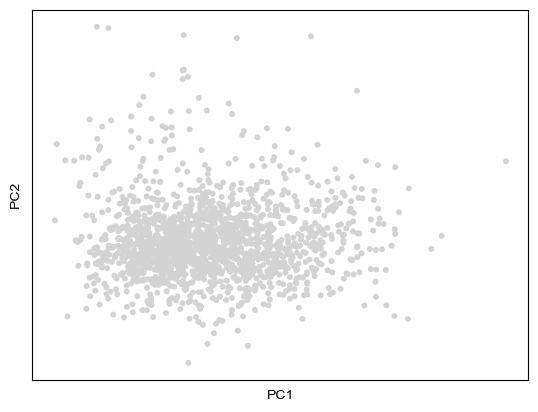

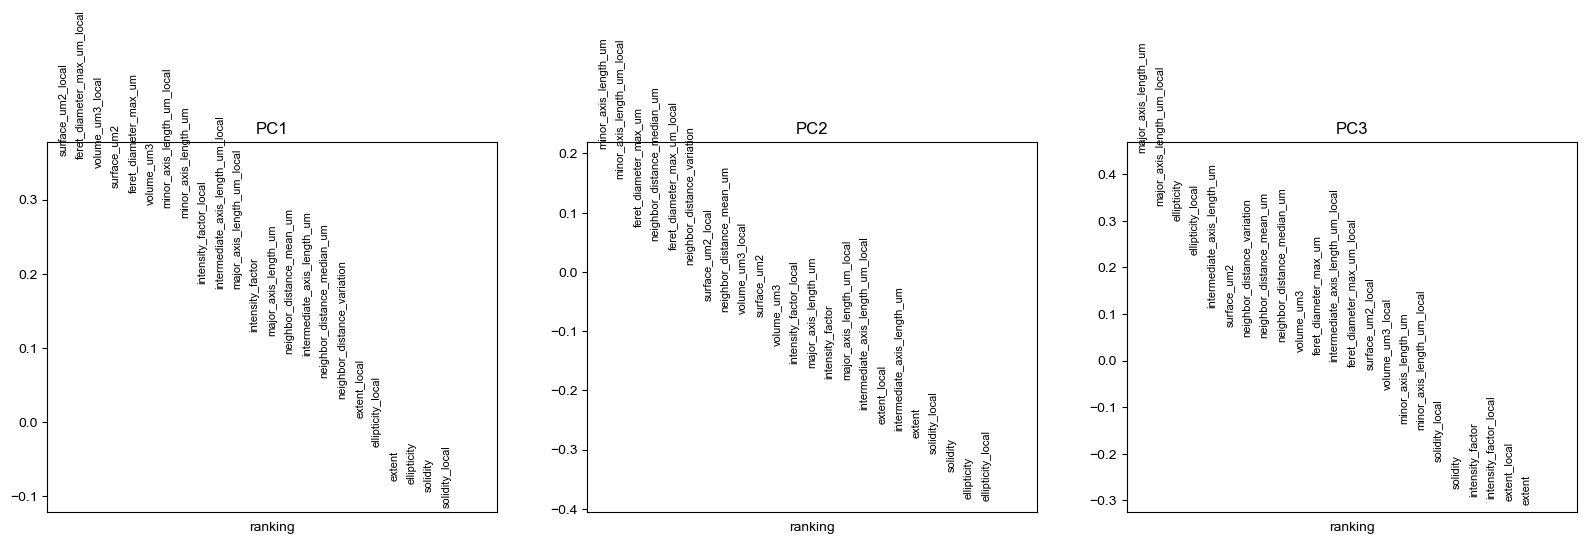

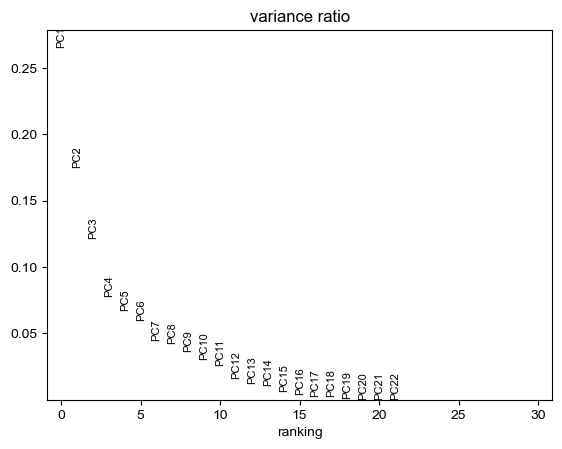

In [ ]:
scanpy.plotting.pca_overview(adata)

# UMAP clustering
Do UMAP clustering:

In [ ]:
scanpy.preprocessing.neighbors(adata, n_pcs=10)
scanpy.tools.umap(adata)


And make some plots out of it:

d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


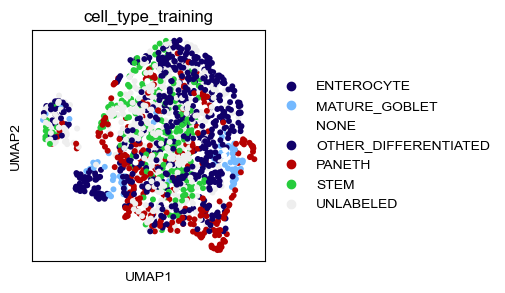

In [ ]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="cell_type_training", ax=fig.gca(), palette=cell_type_palette)

d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


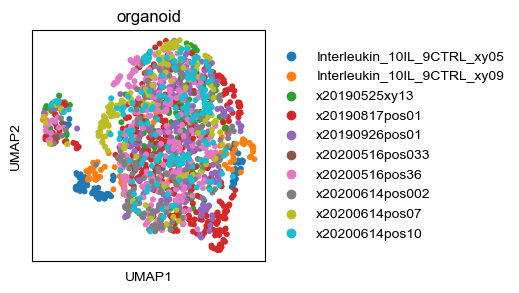

In [ ]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="organoid", ax=fig.gca())

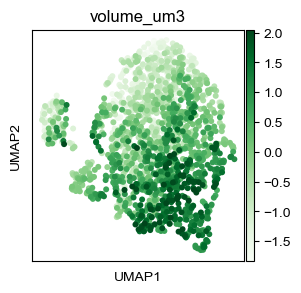

In [ ]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="volume_um3", color_map="Greens", ax=fig.gca())

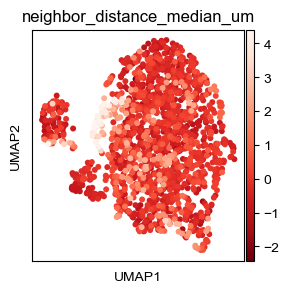

In [ ]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="neighbor_distance_median_um", color_map="Reds_r", ax=fig.gca())

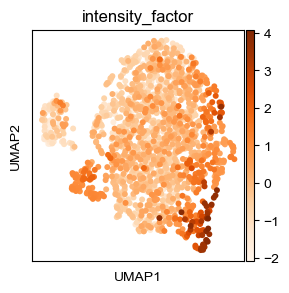

In [ ]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="intensity_factor", color_map="Oranges", ax=fig.gca())

# Most important variables for each cell type

d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


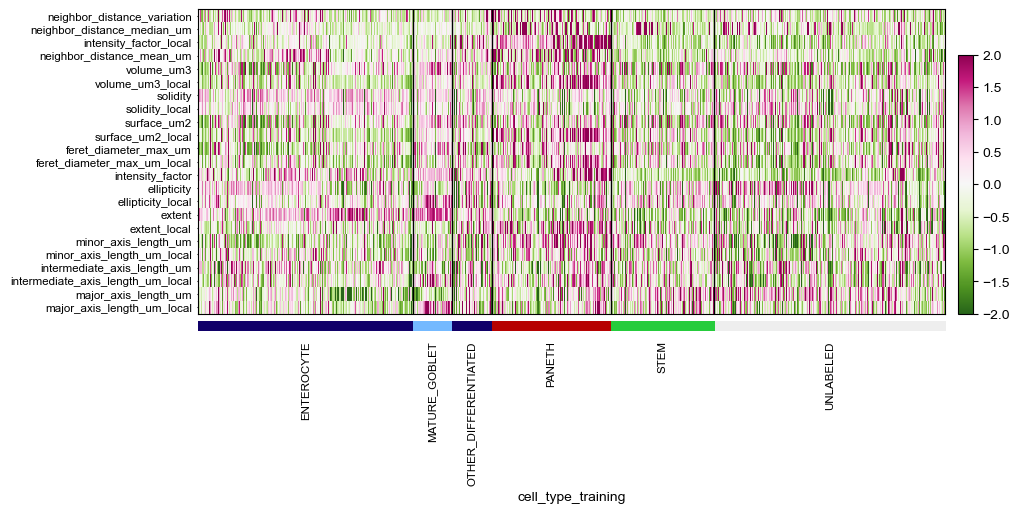

In [ ]:
adata_with_type = adata[adata.obs["cell_type_training"] != "NONE"]
scanpy.plotting.heatmap(adata_with_type,
                        var_names=adata.var_names, 
                        groupby="cell_type_training", 
                        cmap="PiYG_r", 
                        swap_axes=True, 
                        vmin=-2,
                        vmax=2,
                        save="heatmap.svg")


d:\miniconda\envs\organoid_tracker\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = n

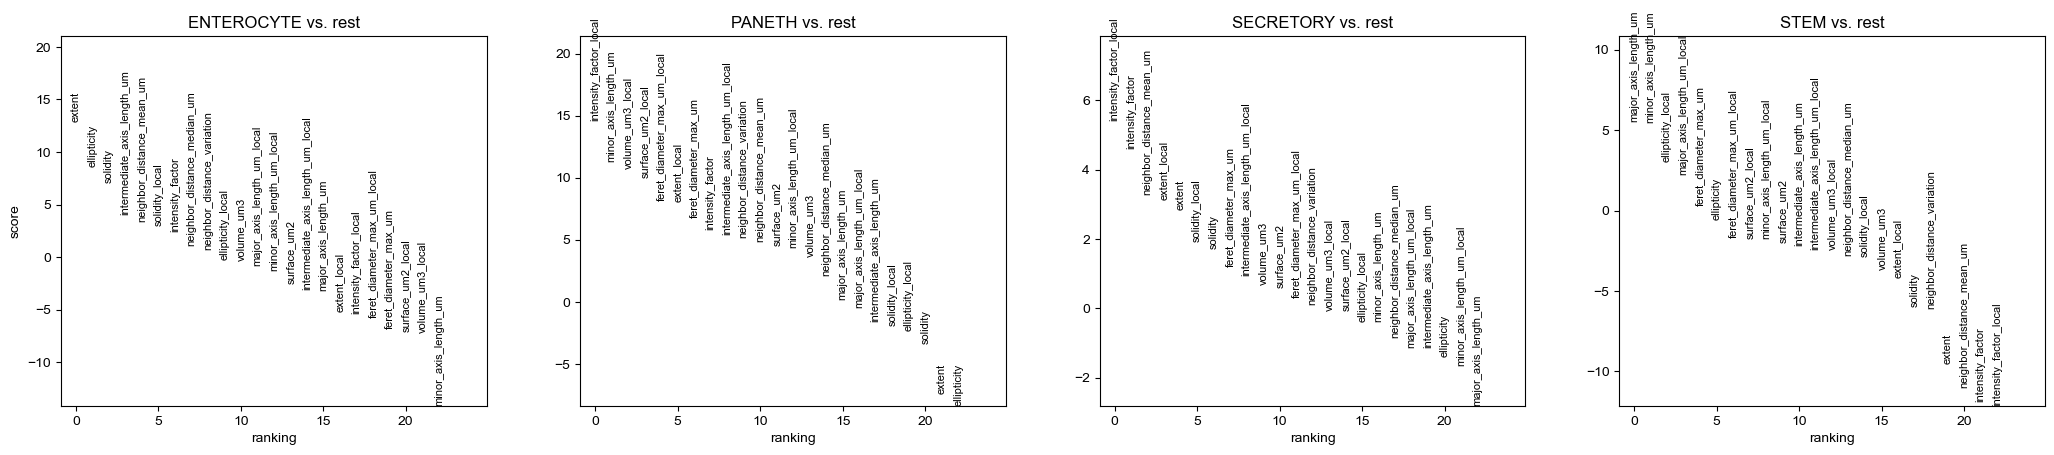

In [ ]:
scanpy.tools.rank_genes_groups(adata_with_type, 'cell_type_training', method='wilcoxon')
scanpy.plotting.rank_genes_groups(adata_with_type, n_genes=25, sharey=False)

Define a p-adjust function:

In [ ]:
def p_adjust_benjamini_hochberg(p_values):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p_values = numpy.array(p_values)
    by_descend = p_values.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p_values)) / numpy.arange(len(p_values), 0, -1)
    q_values = numpy.minimum(1, numpy.minimum.accumulate(steps * p_values[by_descend]))
    return q_values[by_orig]

In [ ]:
# Use Anova to find variables that are significantly different among groups
groups_by_type = adata_with_type.obs.groupby("cell_type_training").indices

rows = list()
for i, var_name in enumerate(adata_with_type.var_names):
    values_by_cell_type = list()
    for cell_type, indices in groups_by_type.items():
        values_by_cell_type.append(adata_with_type.X[indices, i])
    f_stat, p_value = scipy.stats.f_oneway(*values_by_cell_type)
    rows.append((var_name, p_value))

data_frame = pandas.DataFrame(rows, columns=["var_name", "p_value"]).sort_values("p_value")

# Adjust the p values
data_frame["p_value"] = p_adjust_benjamini_hochberg(data_frame["p_value"])

print(data_frame)


                             var_name        p_value
2              intensity_factor_local  8.078357e-133
15                             extent  7.322562e-101
12                   intensity_factor   6.051655e-65
5                    volume_um3_local   1.229612e-57
9                   surface_um2_local   3.406943e-45
17               minor_axis_length_um   6.681660e-44
21               major_axis_length_um   4.922370e-43
3           neighbor_distance_mean_um   1.837542e-41
16                       extent_local   3.952722e-29
20  intermediate_axis_length_um_local   9.035989e-22
11        feret_diameter_max_um_local   2.774332e-19
6                            solidity   6.740084e-19
0         neighbor_distance_variation   4.723582e-18
13                        ellipticity   1.253436e-15
10              feret_diameter_max_um   3.781036e-12
22         major_axis_length_um_local   7.644800e-11
4                          volume_um3   4.286703e-10
14                  ellipticity_local   2.5642

In [ ]:
most_important_variables = list(data_frame["var_name"][0:10])
print(most_important_variables)

['intensity_factor_local', 'extent', 'intensity_factor', 'volume_um3_local', 'surface_um2_local', 'minor_axis_length_um', 'major_axis_length_um', 'neighbor_distance_mean_um', 'extent_local', 'intermediate_axis_length_um_local']


# Clustering using only most important variables

In [ ]:
variable_is_important = [var_name in most_important_variables for var_name in adata_with_type.var_names]

adata_important_only = adata_with_type[:, variable_is_important]


d:\miniconda\envs\organoid_tracker\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


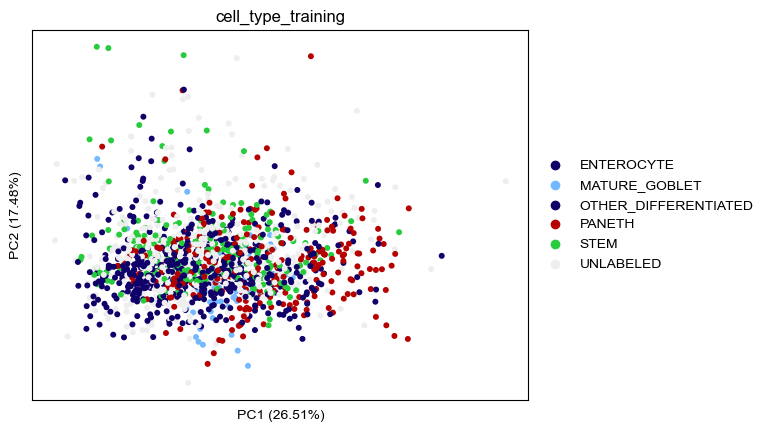

In [ ]:
scanpy.plotting.pca(adata_important_only, annotate_var_explained=True, color="cell_type_training", palette=cell_type_palette)

In [ ]:
scanpy.preprocessing.neighbors(adata_important_only, n_pcs=10)
scanpy.tools.umap(adata_important_only)

d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


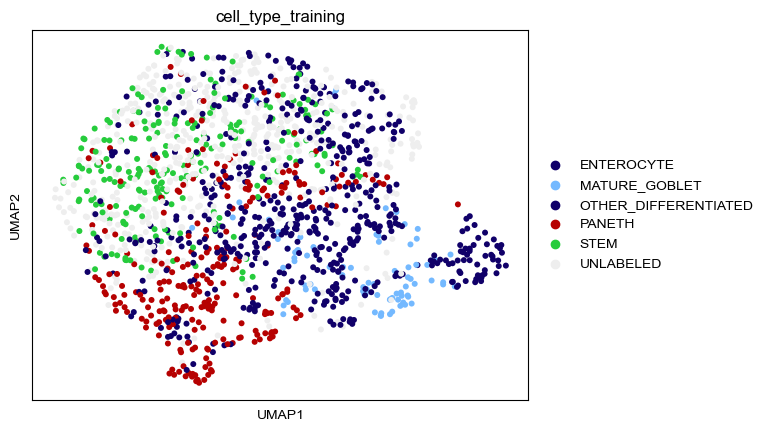

In [ ]:
scanpy.plotting.umap(adata_important_only, color="cell_type_training", palette=cell_type_palette)